# Introduction to Quantitative Finance

Copyright (c) 2019 Python Charmers Pty Ltd, Australia, <https://pythoncharmers.com>. All rights reserved.

<img src="img/python_charmers_logo.png" width="300" alt="Python Charmers Logo">

Published under the Creative Commons Attribution-NonCommercial 4.0 International (CC BY-NC 4.0) license. See `LICENSE.md` for details.

Sponsored by Tibra Global Services, <https://tibra.com>

<img src="img/tibra_logo.png" width="300" alt="Tibra Logo">


## Module 1.5: Bayesian inference

### 1.5.2 Basics of Bayesian inference

Bayesian inference allows us to incorporate existing knowledge into our analysis. This previous knowledge is known as a *prior*, and will affect our results. Choosing a good prior, however, is not that important if you have lots of data. With data, your prior becomes just the starting point, with a minimal effect on the results.

Such *a priori* information can come from population statistics, estimations, or other sources. Using a population statistic, or a default (all outcomes equally likely) is a normal starting place.

### Example 1: Medical diagnosis

Guido wakes up with spots all over his face. What is the probability he has smallpox?

We can't observe the causes (they are latent), only the data. Bayes' theorem allows us to invert this to make inferences about the unknown causes.

From public medical statistics we know that 90% of people with smallpox have spots, whereas 80% of people with chickenpox have spots. This gives us the following likelihoods:

$$p(\textrm{spots | smallpox}) = 0.9$$

$$p(\textrm{spots | chickenpox}) = 0.8$$

From population statistics gathered, we also know that 50 people in every 1000 have spots and that 1 in every million people have smallpox.

### Bayes' theorem

Let $D$ be the observed data and $M$ be a certain model for the data (or hypothesis).

Bayes' theorem can be derived from the laws of probability. It states:

$$
p(M | D) = p(M) \times \frac{p(D|M)}{p(D)}
$$

$$
\textrm{posterior} = \textrm{prior } \times \frac{\textrm{likelihood}}{\textrm{ evidence}}
$$

### Likelihood

The "likelihood of smallpox" is the conditional probability of spots (the data) given that the patient has smallpox (the model / diagnosis). In other words, if we assume the outcome, what is the probability of seeing this data?

In [1]:
def likelihood(data, model):
    """
    Conditional probability of the data ('spots' / 'no spots') given the model
    ('smallpox' / 'not smallpox').
    """
    if data == 'spots':
        return {'smallpox': 0.9, 'not smallpox': 0.05}[model]
    else:
        return {'smallpox': 0.1, 'not smallpox': 0.95}[model]

In [2]:
likelihood('spots', 'smallpox')  # If a patient has small pox, there is a 90% chance they have spots

0.9

### Prior

The "prior" reflects our "prior knowledge" expressed as a background level of belief. What is the background prevalence of smallpox in the general population?

Generally, and without seeing any data, not many people have smallpox. If you checked a random person, it is *much* more likely they would not have small pox. Note that this value ignores any data (like the presence of spots).

In [3]:
def prior(model):
    return {'smallpox': 1e-6, 'not smallpox': 1 - 1e-6}.get(model)

The evidence and posterior have definitions in terms of each other (but for the normalization flag). The evidence function tells us the probability of seeing the given evidence.

In [4]:
def evidence(data):
    """
    The proportion of people in the general population who have spots or no spots
    """
    return (posterior('smallpox', data, normalize=False) +
            posterior('not smallpox', data, normalize=False))

In [5]:
def posterior(model, data, normalize=True):
    """
    Posterior probability of the model ('smallpox / 'not smallpox')
    given the data ('spots' / 'no spots')
    """
    numerator = likelihood(data, model) * prior(model)
    if not normalize:
        return numerator
    else:
        return numerator / evidence(data)

In [6]:
evidence('spots')

0.05000085

In [7]:
posterior('smallpox', 'spots', normalize=True)

1.799969400520191e-05

In [8]:
posterior('smallpox', 'no spots', normalize=True)

1.052632520776466e-07

In [9]:
posterior('not smallpox', 'spots', normalize=True)

0.9999820003059948

In [10]:
posterior('not smallpox', 'no spots', normalize=True)

0.999999894736748

#### Exercises

1. Check that substituting $x$ above correctly leads to the sum of both model probabilities (given spots and given no spots) to be 1
2. We learn from public medical records that 80% of people with chickenpox have spots and that 1 in every 10,000 people have chickenpox. (As before, 1 in every 20 people have spots.)
3. Suppose $x$ (the probability of spots without chickenpox) were much higher, like among teenagers. How would this affect the posterior probability of chickenpox? First, consider this intuitively, then run the code again to check your understanding.

Repeat the above steps for chickenpox.

*For the solution to exercise 1, see `solutions/check_normalized.py`*

*For the solution to exercise 2 see `solutions/public_medical.py`*

#### Question does it matter for normalization what the value of $x$ is?

Try a few values using `conditional_sum.subs(x, value)`.

In [1]:
# You'll need to run the solution in this notebook to continue
%run -i solutions/public_medical.py

In [17]:
posterior('chickenpox', 'spots', x=0.5)  # If 50% of those with spots do not have chicken pox

0.00039988003598920324

### Model comparison

If we want to compare two models or hypotheses for the given data, we can compare the ratio of posterior probabilities (also known as posterior odds) between the two hypotheses.

Here, with hypotheses $\theta_c$ (Guido has chickenpox) and $\theta_s$ (Guido has smallpox):

$$
R_{\textrm{posterior}} = \frac{p(\theta_c | x)}{p(\theta_s | x)}
$$

If we apply Bayes' rule, the marginal likelihoods cancel, so:

$$
R_\textrm{posterior} = \frac{p(x | \theta_c)}{p(x | \theta_s)} \frac{p(\theta_c)}{p(\theta_s)}
$$

$$
\textrm{posterior odds} = \textrm{Bayes factor} \times \textrm{prior odds}
$$

### Bayesian hypothesis testing

We can do Bayesian hypothesis testing by calculating the Bayes factor, prior odds, and posterior odds for the hypothesis of chickenpox vs smallpox.


### Example 2: flipping coins

**Question:** How would you decide how unfair a coin is, based on just two coin flips?

Define $p(\theta)$ as the probability that the coin has a given bias $\theta$. Define bias of 1 to be *always heads* and a bias of 0 to be *always tails*.

Start with the likelihood, $p(x | \theta)$

In [18]:
import numpy as np
import scipy.stats
import matplotlib.pyplot as plt
%matplotlib inline

In [19]:
def likelihood(data, theta):
    """
    Conditional probability of the data (x heads out of N coin tosses),
    given the bias theta of the model (potentially biased).
    """
    x, N = data
    return scipy.stats.binom(N, theta).pmf(x)

In [20]:
N = 15

In [21]:
likelihood([5, 15], 0.3)

0.20613038097752118

Now we will choose a prior. Let's go with a Beta prior. (Look up "conjugate priors".)

In [22]:
def prior(theta, a, b):
    return scipy.stats.beta(a, b).pdf(theta)

In [23]:
prior(0.8, 1, 2)  # In a beta distribution with params (1, 2), there is a 40% chance of seeing 80% heads

0.3999999999999999

In [24]:
params = [0.5, 1, 2, 3]
x = np.linspace(0, 1, 100)

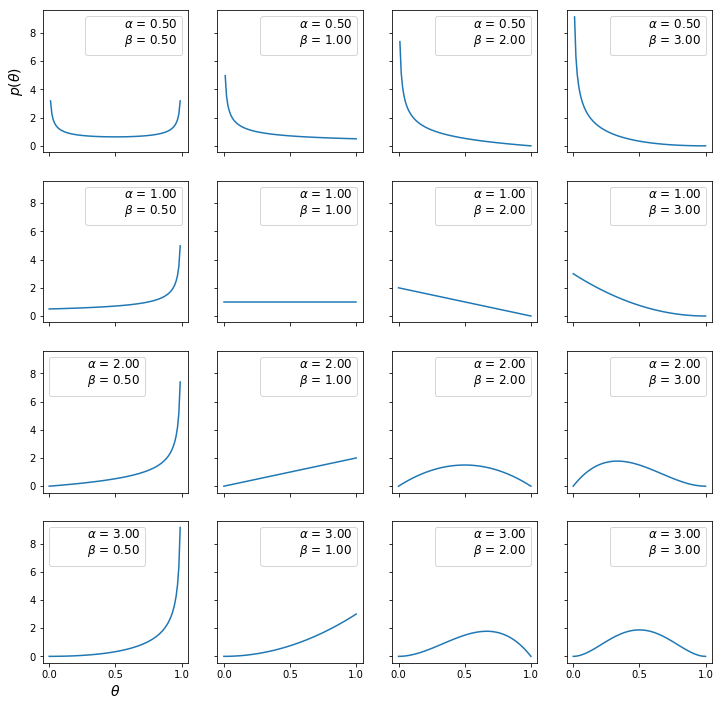

In [25]:
%run plot_priors.ipy

#### Exercise

Which do you think best matches the belief that the coin is:
1. more likely to be fair than biased
1. just as likely to be biased as fair
1. probably biased towards heads


*For solutions, see `solutions/best_coin.py`*

### Now, how to incorporate the data?

Once we have our prior, we now collect data. This data is then used to update our model, better informing our outcome.

### Evidence / marginal posterior

The evidence for the data is now: $$p(\textrm{data}) = \int_{0}^1 d\theta \space p(\textrm{data | }\theta) p(\theta)$$

In [27]:
from scipy.integrate import quad

def evidence(data):
    def lik(theta):
        return likelihood(data, theta)
    def post(theta):
        return lik(theta) * prior(theta, alpha, beta)
    evidence, abserr = quad(post, 0, 1, )
    return evidence

For now, we will just fix these: ("just as likely biased as fair"):

In [28]:
(a, b) = (1, 1)

In [29]:
trials = [0, 1, 2, 3, 4, 8, 16, 32, 50, 150]
data = [0, 1, 1, 1, 1, 4, 6, 9, 13, 48]
theta = np.linspace(0, 1)

In [30]:
def lik(theta):
    return likelihood((data[-1], trials[-1]), theta)
lik(theta)[:10]

array([0.00000000e+00, 4.33764125e-43, 1.42583319e-29, 4.50574362e-22,
       4.75557907e-17, 2.15466932e-13, 1.30523859e-10, 1.93544556e-08,
       1.00674662e-06, 2.31423249e-05])

In [31]:
evidence((data[-1], trials[-1]))

0.009392766325311568

In [32]:
def posterior(model, data, normalize=True):
    """
    Posterior probability of the model given the data
    """
    numerator = likelihood(data, model) * prior(model, a, b)
    if not normalize:
        return numerator
    else:
        return numerator / evidence(data)

In [33]:
posterior(0.4, (15, 50))

1.5956869799149278

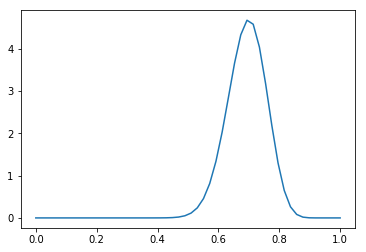

In [34]:
plt.plot(theta, [posterior(t, (35, 50)) for t in theta])

In [35]:
beta_params = ((2, 2), (1, 1), (1, 0.5))

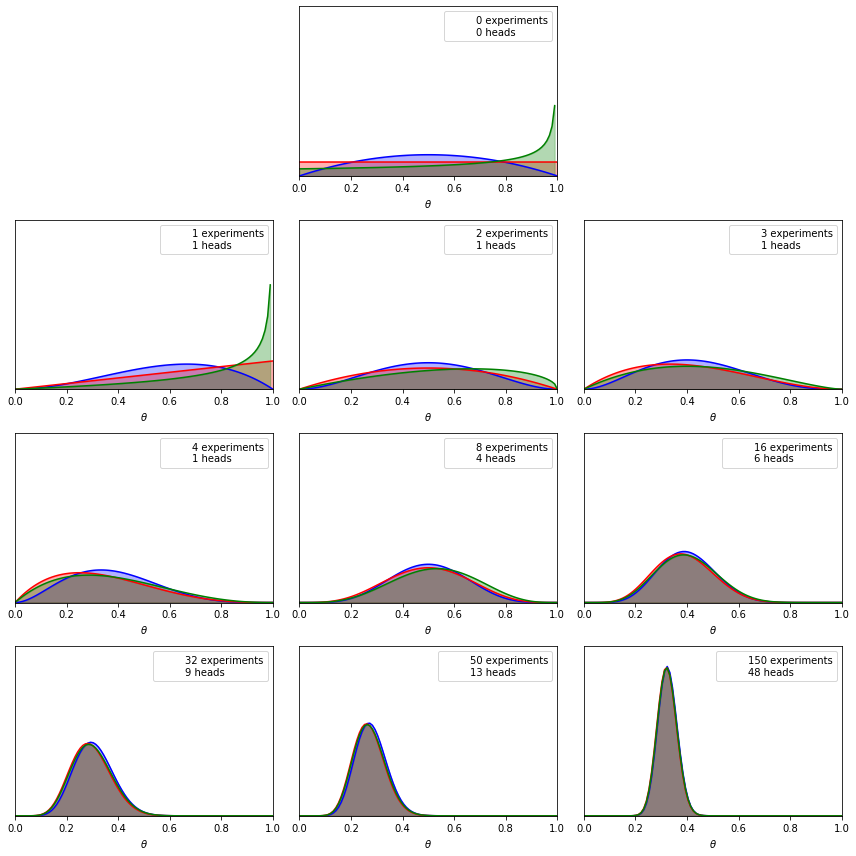

In [36]:
%run show_posteriors_coins.ipy

### Result

The result of Bayesian inference is a posterior **probability distribution**. This gives us more information than just the single most probable model or hypothesis; it also gives us information about the error associated with each choice.

### Credible intervals

A convenient way to summarize the spread of the posterior distribution is with a "credible interval" of "Highest Posterior Density (HPD). This is the shortest interval containing a given portion of the probability density (such as 50%, 95% or 98%).

#### Extended Exercise
Implement this function:

In [37]:
def hpd(posterior, alpha=0.05):
    """
    A (1 - α) credible interval
    
    Parameters
    ----------
    posterior : function
        A posterior probability density function (normalized)
    
    alpha : float
        A significance level (of sorts)
        
    Returns
    -------
        A tuple (lower, upper) giving the lower and upper bounds for
        the (1 - α) credible interval
    """
    ...

You might try using `scipy.integrate.quad`.

### Diachronic Interpretation

The "Diachronic Interpretation" of Bayesian statistics is the application of the key equation over time, specifically as we collect new data. This allows us to update the likelihood of our probabilities.

We saw it above with our coin flips. As we flip more coins, we collect more data, giving us a greater understanding of whether the coin is fair or not.

When performing a Diachronic Interpretation, you want your hypotheses to have the following two properties:

1. the hypotheses are mutually exclusive and only one can be true, and
2. the hypotheses are exhaustive, and no other possibility is possible.


You can definitely perform a Bayesian analysis when the above properties are not true, but the analysis is harder and more care needs to be taken in your analysis.

Specifically, we rewrite Bayes formula with $H$ and $D$:

$P(H|D) = \frac{P(H)P(D|H)}{P(D)}$

Where:

* P(H|D) is the probability of the hypothesis we are interested in, given we have seen the data $D$, called the **posterior**.
* P(H) is the probability of the hypothesis itself, given no data was seen. A normal approach here is to simply consider all hypothesis likely, unless you have some other reasonable value. This is known as the **prior**.
* P(D|H) is the probability we would see the data, assuming the hypothesis is true, known as the **likelihood**.
* P(D) is the probability we would see the data, and is a **normalisation factor**.


That last value, $P(D)$ is the same for all hypotheses we would be considering, meaning that we could simply not compute it. This happens in the Naive Bayes algorithm in machine learning, and has no detremental impact on the decision making process, but it does mean that the values you get after applying Bayes theorem are not actually probabilities.

#### Extended exercise

Start with the following two hypotheses:

1. The gold price is correlated with the (1 day lagged) GBP/USD conversion rate.
2. The gold price is uncorrelated with the GPB/USD conversion rate.

Potential data sources:
* Gold prices: https://www.quandl.com/data/LBMA/GOLD-Gold-Price-London-Fixing
* GBP/USD: https://www.quandl.com/data/BUNDESBANK/BBEX3_D_GBP_USD_CM_AC_000-Exchange-Rates-For-The-Us-Dollar-In-The-United-Kingdom-Gbp-1-Usd-middle

Using a diachronic interpretation of Bayes Theorem, which of the stated hypothesis is true?

Some pointers to get you started:

1. Create a definition for "is correlated" before you start. You may choose, for example, "if $R^2 > 0.7$"
1. Get both datasets, clean them up and create a single DataFrame with the values we are interested in
1. Perform a Linear Regression using the previous techniques and review the confidence interval and $R^2$ data. While this is unrelated to the Bayes theorem, you can use your result here to give you an expectation on the results of this exercise. 
1. The prior probability can simply be 50% for each theorem, as without data, we don't really have any way to change from this.
1. The probability of the data does not need to be computed for comparing hypothesis